Summary Statistics:
       MFCC_mean_1  MFCC_mean_2  MFCC_mean_3  MFCC_mean_4  MFCC_mean_5  \
count   116.000000   116.000000   116.000000   116.000000   116.000000   
mean   -223.685816   149.294454   -39.298437    33.742982     3.276054   
std      48.179351    30.305888    24.148395    22.530922    15.857214   
min    -446.827918    91.387647   -93.961705   -28.187547   -30.221894   
25%    -257.472932   127.234253   -56.828854    25.974569    -6.874532   
50%    -221.786107   141.293248   -43.571203    38.870333    -0.112606   
75%    -191.291758   166.712191   -20.156386    48.312487    11.068414   
max    -106.734410   228.158156    26.270366    79.220040    47.968517   

       MFCC_mean_6  MFCC_mean_7  MFCC_mean_8  MFCC_mean_9  MFCC_mean_10  ...  \
count   116.000000   116.000000   116.000000   116.000000    116.000000  ...   
mean      7.480534    -5.404420     5.753877    -5.975003     -1.893513  ...   
std      13.167991     8.461683     9.112946     5.820130      5.835531  

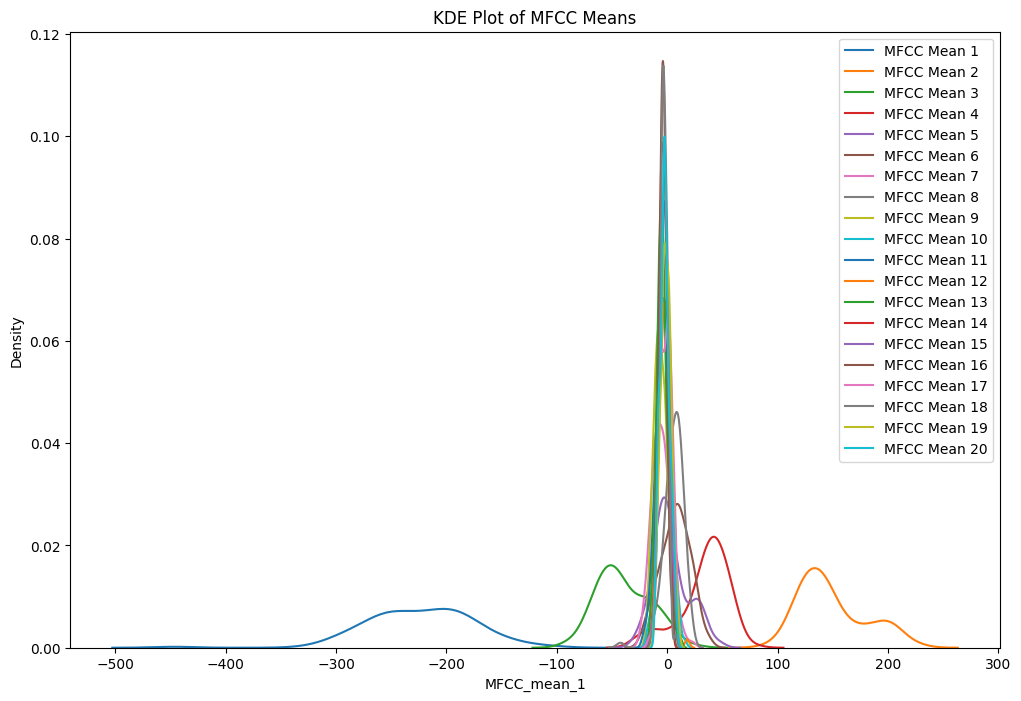

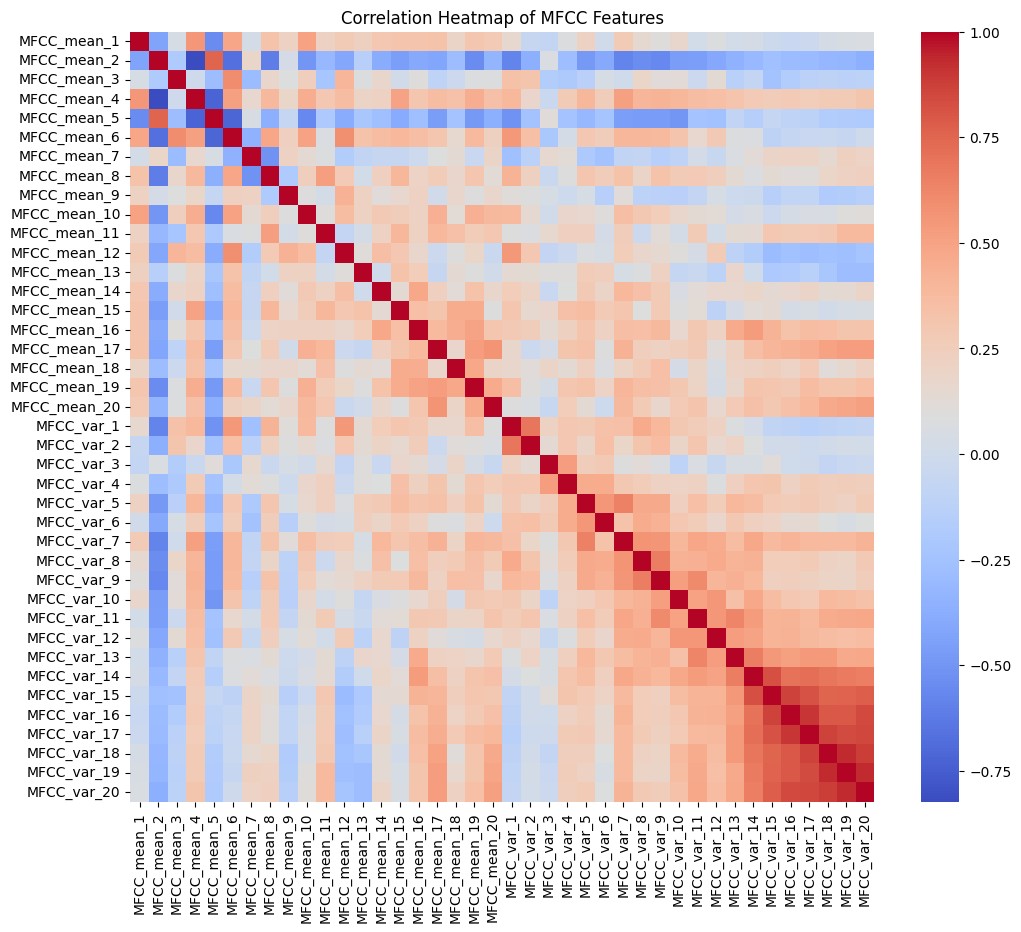

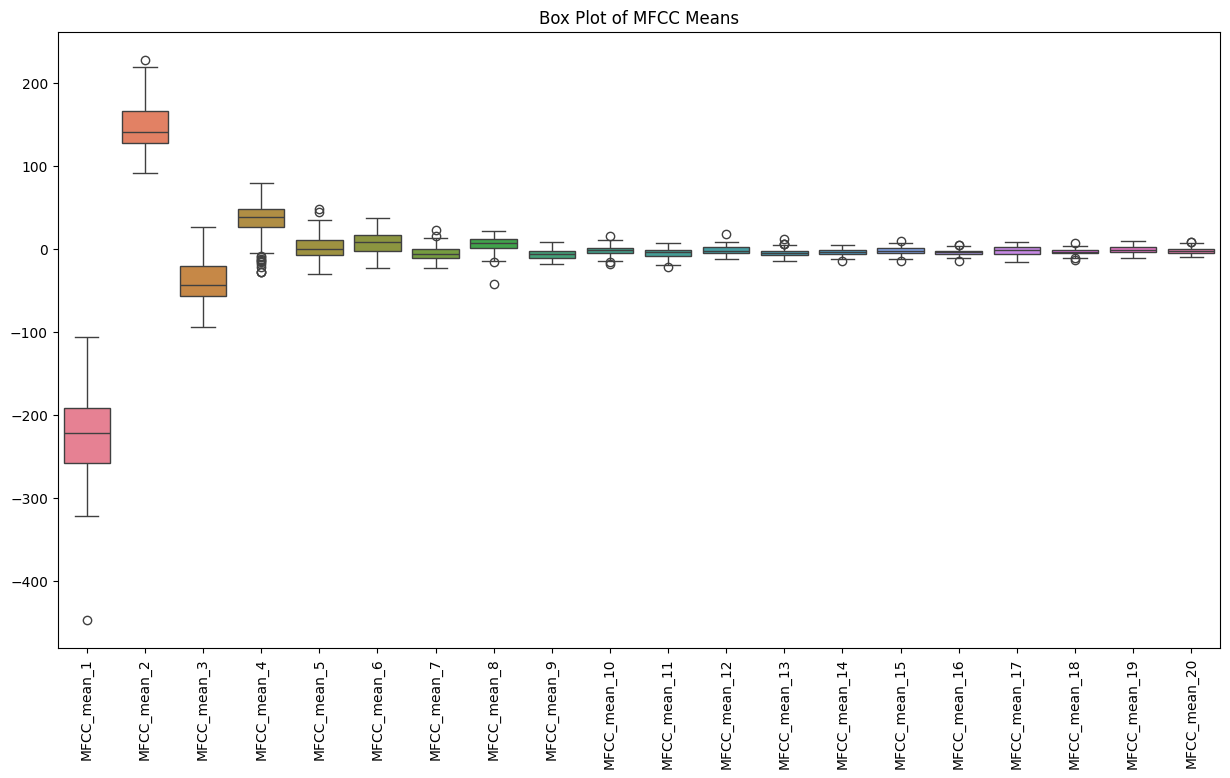

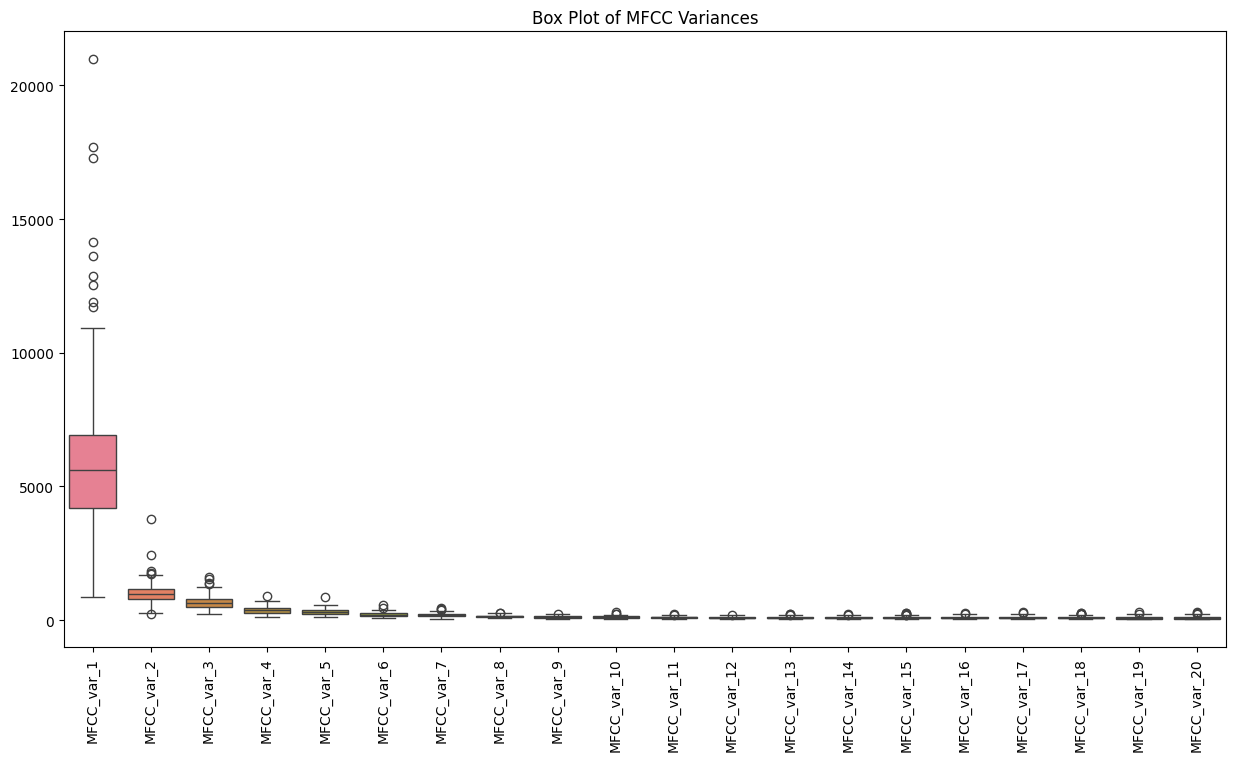

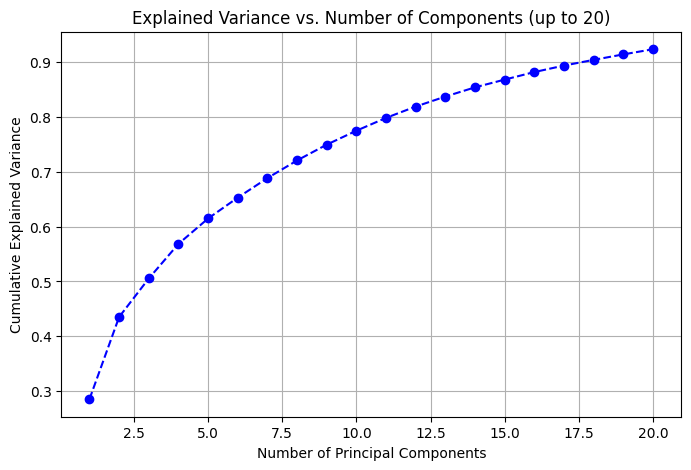

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mfcc_dir = r'E7\FOLDER'

mfcc_data = []
song_labels = []

for file_name in os.listdir(mfcc_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(mfcc_dir, file_name)
        df = pd.read_csv(file_path, header=None)
        
        mfcc_means = df.mean(axis=1).values
        mfcc_vars = df.var(axis=1).values
        features = np.concatenate([mfcc_means, mfcc_vars])
        
        mfcc_data.append(features)
        song_labels.append(file_name)


mfcc_df = pd.DataFrame(mfcc_data, columns=[f'MFCC_mean_{i+1}' for i in range(20)] + [f'MFCC_var_{i+1}' for i in range(20)])


print("Summary Statistics:")
print(mfcc_df.describe())


plt.figure(figsize=(12, 8))
for i in range(20):
    sns.kdeplot(mfcc_df[f'MFCC_mean_{i+1}'], label=f'MFCC Mean {i+1}')
plt.title("KDE Plot of MFCC Means")
plt.legend()
plt.show()


corr_matrix = mfcc_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of MFCC Features')
plt.show()


plt.figure(figsize=(15, 8))
sns.boxplot(data=mfcc_df.iloc[:, :20])  
plt.title('Box Plot of MFCC Means')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 8))
sns.boxplot(data=mfcc_df.iloc[:, 20:]) 
plt.title('Box Plot of MFCC Variances')
plt.xticks(rotation=90)
plt.show()


scaler = StandardScaler()
mfcc_data_scaled = scaler.fit_transform(mfcc_df)

pca = PCA(n_components=20)
pca.fit(mfcc_data_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (up to 20)')
plt.grid()
plt.show()



100%|██████████| 113/113 [01:46<00:00,  1.06it/s]


GMM Silhouette Score: 0.4481
GMM Davies-Bouldin Score: 0.8305
GMM Calinski-Harabasz Index: 152.1893
GMM clustering results saved to 'results_gmm.csv'

KMeans Clustering Metrics:
Silhouette Score: 0.4769
Davies-Bouldin Score: 0.7677
Calinski-Harabasz Index: 206.9050

Agglomerative Clustering Metrics:
Silhouette Score: 0.4698
Davies-Bouldin Score: 0.7225
Calinski-Harabasz Index: 186.4346

GMM visualization saved as 'cluster_visualization_gmm.png'

Final Metrics Summary:

GMM: Silhouette Score = 0.4481, Davies-Bouldin = 0.8305, Calinski-Harabasz = 152.1893
KMeans: Silhouette Score = 0.4769, Davies-Bouldin = 0.7677, Calinski-Harabasz = 206.9050
Agglomerative: Silhouette Score = 0.4698, Davies-Bouldin = 0.7225, Calinski-Harabasz = 186.4346


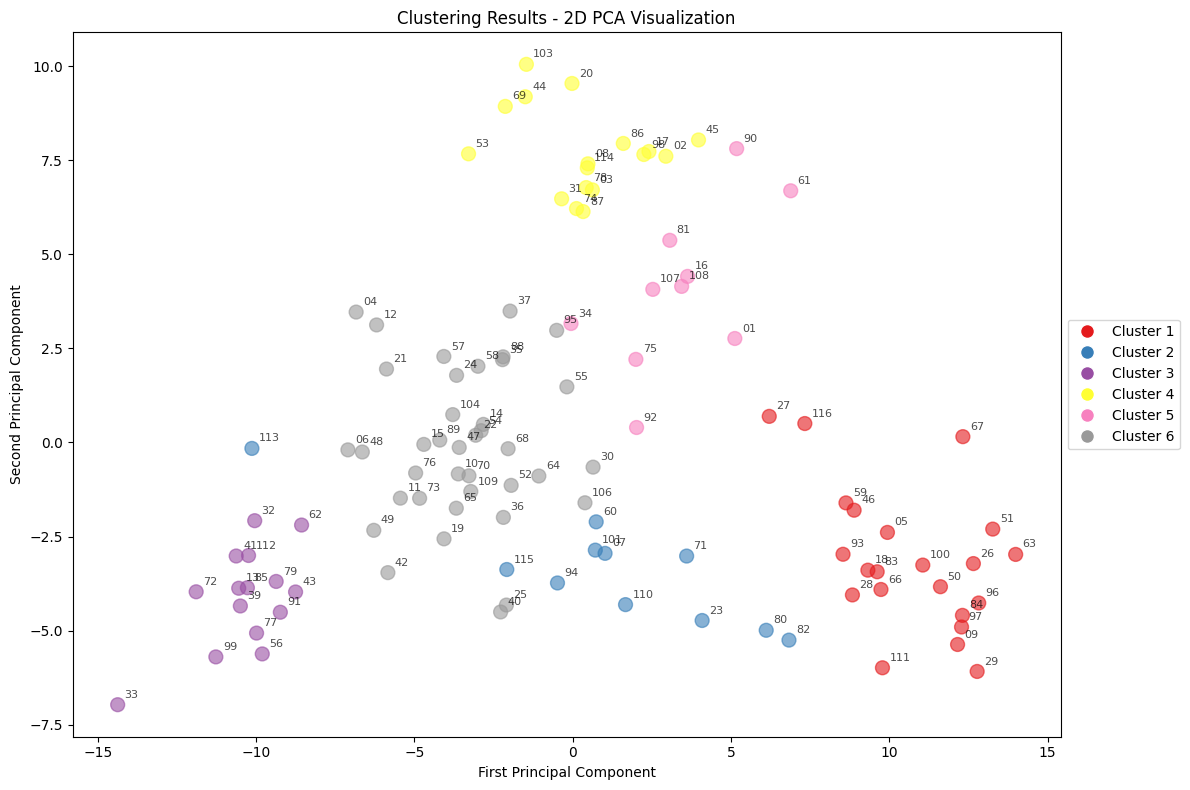

In [ ]:
import numpy as np
import polars as pl
from scipy import stats
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

file_path = r'C:\Users\Chaitanya Patel\Desktop\IITB Studies\3rd\DS203\E7\FOLDER'

def load_and_process_mfcc(file_path):
    mfcc_data = pl.read_csv(file_path, has_header=False)
    
    if mfcc_data.is_empty() or mfcc_data.shape[0] != 20:
        return None

    features = []
    mfcc_numpy = mfcc_data.to_numpy()
    
    for mfcc_row in mfcc_numpy:
        coefficient_data = mfcc_row.flatten()
        
        # Statistical features
        stats_features = [
            float(np.mean(coefficient_data)),
            float(np.std(coefficient_data)),
            float(np.percentile(coefficient_data, 75)),
            float(np.max(coefficient_data)),
            float(np.min(coefficient_data)),
            float(stats.kurtosis(coefficient_data)),
            float(stats.skew(coefficient_data)),
            float(np.mean(librosa.feature.spectral_bandwidth(y=coefficient_data, sr=44100))),
            float(np.mean(librosa.feature.rms(y=coefficient_data))),
        ]
        features.extend(stats_features)

    return np.array(features, dtype=float)

def plot_clusters_2d(X_pca, cluster_labels, file_names):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Set1', alpha=0.6, s=100)
    
    for i, txt in enumerate(file_names):
        file_num = txt.split('-')[0]
        plt.annotate(file_num, (X_pca[i, 0], X_pca[i, 1]), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), label=f'Cluster {i+1}', markersize=10) for i in range(6)]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Clustering Results - 2D PCA Visualization')
    plt.tight_layout()
    
    return plt.gcf()

def cluster_audio_files(directory_path):
    mfcc_files = glob.glob(os.path.join(directory_path, "*-MFCC.csv"))
    features_list = []
    file_names = []
    
    for file_path in tqdm(mfcc_files):
        features = load_and_process_mfcc(file_path)
        if features is not None:
            features_list.append(features)
            file_names.append(os.path.basename(file_path))
    
    X = np.array(features_list)
    X = X.reshape(-1, 1) if len(X.shape) == 1 else X
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    gmm = GaussianMixture(n_components=6, reg_covar=1e-6, random_state=42)
    cluster_labels = gmm.fit_predict(X_pca)
    
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
    
    print(f"GMM Silhouette Score: {silhouette_avg:.4f}")
    print(f"GMM Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"GMM Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    
    plot = plot_clusters_2d(X_pca, cluster_labels, file_names)
    
    results = pl.DataFrame({
        'File': file_names,
        'Cluster': cluster_labels.tolist()
    })
    
    return results, X_pca, gmm, plot, silhouette_avg, davies_bouldin, calinski_harabasz

def calculate_cluster_metrics(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    
    return silhouette_avg, davies_bouldin, calinski_harabasz

def cluster_with_kmeans(X_pca):
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_pca)
    
    print("\nKMeans Clustering Metrics:")
    kmeans_metrics = calculate_cluster_metrics(X_pca, kmeans_labels)
    
    return kmeans, kmeans_labels, kmeans_metrics

def cluster_with_agglomerative(X_pca):
    agglomerative = AgglomerativeClustering(n_clusters=6)
    agglomerative_labels = agglomerative.fit_predict(X_pca)
    
    print("\nAgglomerative Clustering Metrics:")
    agglomerative_metrics = calculate_cluster_metrics(X_pca, agglomerative_labels)
    
    return agglomerative, agglomerative_labels, agglomerative_metrics

if __name__ == "__main__":
    directory_path = r'C:\Users\Chaitanya Patel\Desktop\IITB Studies\3rd\DS203\E7\FOLDER'
    
    
    results, X_pca, gmm, plot, silhouette_avg, davies_bouldin, calinski_harabasz = cluster_audio_files(directory_path)
    
   
    results.write_csv('results_gmm.csv')
    print("GMM clustering results saved to 'results_gmm.csv'")
    
   
    kmeans, kmeans_labels, kmeans_metrics = cluster_with_kmeans(X_pca)
    
   
    agglomerative, agglomerative_labels, agglomerative_metrics = cluster_with_agglomerative(X_pca)
    
   
    plot.savefig('cluster_visualization_gmm.png', dpi=300, bbox_inches='tight')
    print("\nGMM visualization saved as 'cluster_visualization_gmm.png'")
    
  
    print("\nFinal Metrics Summary:")
    print(f"\nGMM: Silhouette Score = {silhouette_avg:.4f}, Davies-Bouldin = {davies_bouldin:.4f}, Calinski-Harabasz = {calinski_harabasz:.4f}")
    print(f"KMeans: Silhouette Score = {kmeans_metrics[0]:.4f}, Davies-Bouldin = {kmeans_metrics[1]:.4f}, Calinski-Harabasz = {kmeans_metrics[2]:.4f}")
    print(f"Agglomerative: Silhouette Score = {agglomerative_metrics[0]:.4f}, Davies-Bouldin = {agglomerative_metrics[1]:.4f}, Calinski-Harabasz = {agglomerative_metrics[2]:.4f}")


100%|██████████| 113/113 [01:44<00:00,  1.08it/s]


KMeans Silhouette Score: 0.4769
KMeans Davies-Bouldin Score: 0.7677
KMeans Calinski-Harabasz Index: 206.9050
KMeans clustering results saved to 'results_kmeans.csv'

KMeans visualization saved as 'cluster_visualization_kmeans.png'

KMeans Clustering Metrics Summary:
Silhouette Score = 0.4769
Davies-Bouldin Score = 0.7677
Calinski-Harabasz Index = 206.9050


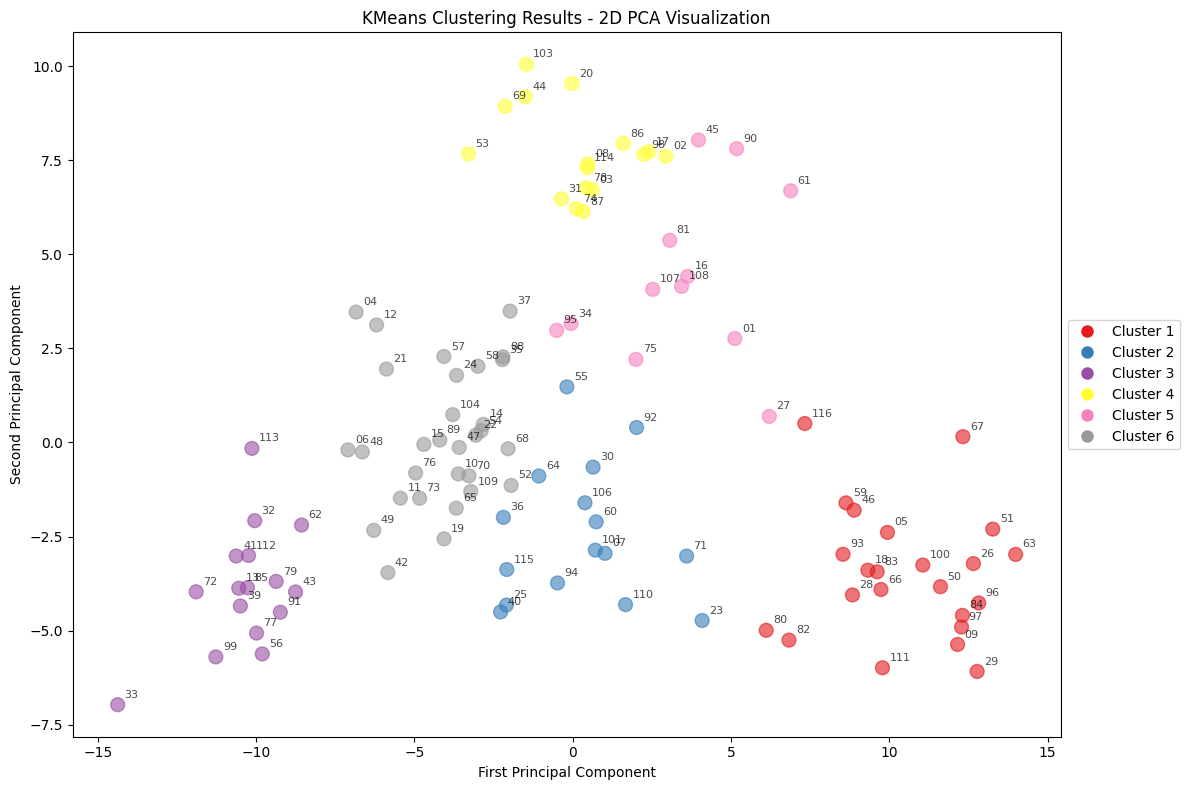

In [ ]:
import numpy as np
import polars as pl
from scipy import stats
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

file_path = r'C:\Users\Chaitanya Patel\Desktop\IITB Studies\3rd\DS203\E7\FOLDER'

def load_and_process_mfcc(file_path):
    mfcc_data = pl.read_csv(file_path, has_header=False)
    
    if mfcc_data.is_empty() or mfcc_data.shape[0] != 20:
        return None

    features = []
    mfcc_numpy = mfcc_data.to_numpy()
    
    for mfcc_row in mfcc_numpy:
        coefficient_data = mfcc_row.flatten()
        
        
        stats_features = [
            float(np.mean(coefficient_data)),
            float(np.std(coefficient_data)),
            float(np.percentile(coefficient_data, 75)),
            float(np.max(coefficient_data)),
            float(np.min(coefficient_data)),
            float(stats.kurtosis(coefficient_data)),
            float(stats.skew(coefficient_data)),
            float(np.mean(librosa.feature.spectral_bandwidth(y=coefficient_data, sr=44100))),
            float(np.mean(librosa.feature.rms(y=coefficient_data))),
        ]
        features.extend(stats_features)

    return np.array(features, dtype=float)

def plot_clusters_2d(X_pca, cluster_labels, file_names):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Set1', alpha=0.6, s=100)
    
    for i, txt in enumerate(file_names):
        file_num = txt.split('-')[0]
        plt.annotate(file_num, (X_pca[i, 0], X_pca[i, 1]), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), label=f'Cluster {i+1}', markersize=10) for i in range(6)]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('KMeans Clustering Results - 2D PCA Visualization')
    plt.tight_layout()
    
    return plt.gcf()

def cluster_audio_files_kmeans(directory_path):
    mfcc_files = glob.glob(os.path.join(directory_path, "*-MFCC.csv"))
    features_list = []
    file_names = []
    
    for file_path in tqdm(mfcc_files):
        features = load_and_process_mfcc(file_path)
        if features is not None:
            features_list.append(features)
            file_names.append(os.path.basename(file_path))
    
    X = np.array(features_list)
    X = X.reshape(-1, 1) if len(X.shape) == 1 else X
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
  
    kmeans = KMeans(n_clusters=6, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    
   
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
    
    print(f"KMeans Silhouette Score: {silhouette_avg:.4f}")
    print(f"KMeans Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"KMeans Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    
    plot = plot_clusters_2d(X_pca, cluster_labels, file_names)
    
    
    results = pl.DataFrame({
        'File': file_names,
        'Cluster': cluster_labels.tolist()
    })
    
    return results, X_pca, kmeans, plot, silhouette_avg, davies_bouldin, calinski_harabasz

if __name__ == "__main__":
    directory_path = r'C:\Users\Chaitanya Patel\Desktop\IITB Studies\3rd\DS203\E7\FOLDER'
    
   
    results, X_pca, kmeans, plot, silhouette_avg, davies_bouldin, calinski_harabasz = cluster_audio_files_kmeans(directory_path)
    
 
    results.write_csv('results_kmeans.csv')
    print("KMeans clustering results saved to 'results_kmeans.csv'")
    
 
    plot.savefig('cluster_visualization_kmeans.png', dpi=300, bbox_inches='tight')
    print("\nKMeans visualization saved as 'cluster_visualization_kmeans.png'")
    

    print("\nKMeans Clustering Metrics Summary:")
    print(f"Silhouette Score = {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Score = {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Index = {calinski_harabasz:.4f}")


In [ ]:

results_numpy = results.to_numpy()
results_numpy

array([['01-MFCC.csv', 4],
       ['02-MFCC.csv', 3],
       ['03-MFCC.csv', 3],
       ['04-MFCC.csv', 5],
       ['05-MFCC.csv', 0],
       ['06-MFCC.csv', 5],
       ['07-MFCC.csv', 1],
       ['08-MFCC.csv', 3],
       ['09-MFCC.csv', 0],
       ['10-MFCC.csv', 5],
       ['100-MFCC.csv', 0],
       ['101-MFCC.csv', 1],
       ['103-MFCC.csv', 3],
       ['104-MFCC.csv', 5],
       ['106-MFCC.csv', 1],
       ['107-MFCC.csv', 4],
       ['108-MFCC.csv', 4],
       ['109-MFCC.csv', 5],
       ['11-MFCC.csv', 5],
       ['110-MFCC.csv', 1],
       ['111-MFCC.csv', 0],
       ['112-MFCC.csv', 2],
       ['113-MFCC.csv', 2],
       ['114-MFCC.csv', 3],
       ['115-MFCC.csv', 1],
       ['116-MFCC.csv', 0],
       ['12-MFCC.csv', 5],
       ['13-MFCC.csv', 2],
       ['14-MFCC.csv', 5],
       ['15-MFCC.csv', 5],
       ['16-MFCC.csv', 4],
       ['17-MFCC.csv', 3],
       ['18-MFCC.csv', 0],
       ['19-MFCC.csv', 5],
       ['20-MFCC.csv', 3],
       ['21-MFCC.csv', 5],
       ['22-M

In [ ]:

results_dict = results.to_dict(as_series=False)


cluster_labels = {results_dict['File'][i]: results_dict['Cluster'][i] for i in range(len(results_dict['File']))}


print(cluster_labels)


{'01-MFCC.csv': 4, '02-MFCC.csv': 3, '03-MFCC.csv': 3, '04-MFCC.csv': 5, '05-MFCC.csv': 0, '06-MFCC.csv': 5, '07-MFCC.csv': 1, '08-MFCC.csv': 3, '09-MFCC.csv': 0, '10-MFCC.csv': 5, '100-MFCC.csv': 0, '101-MFCC.csv': 1, '103-MFCC.csv': 3, '104-MFCC.csv': 5, '106-MFCC.csv': 1, '107-MFCC.csv': 4, '108-MFCC.csv': 4, '109-MFCC.csv': 5, '11-MFCC.csv': 5, '110-MFCC.csv': 1, '111-MFCC.csv': 0, '112-MFCC.csv': 2, '113-MFCC.csv': 2, '114-MFCC.csv': 3, '115-MFCC.csv': 1, '116-MFCC.csv': 0, '12-MFCC.csv': 5, '13-MFCC.csv': 2, '14-MFCC.csv': 5, '15-MFCC.csv': 5, '16-MFCC.csv': 4, '17-MFCC.csv': 3, '18-MFCC.csv': 0, '19-MFCC.csv': 5, '20-MFCC.csv': 3, '21-MFCC.csv': 5, '22-MFCC.csv': 5, '23-MFCC.csv': 1, '24-MFCC.csv': 5, '25-MFCC.csv': 1, '26-MFCC.csv': 0, '27-MFCC.csv': 4, '28-MFCC.csv': 0, '29-MFCC.csv': 0, '30-MFCC.csv': 1, '31-MFCC.csv': 3, '32-MFCC.csv': 2, '33-MFCC.csv': 2, '34-MFCC.csv': 4, '35-MFCC.csv': 5, '36-MFCC.csv': 1, '37-MFCC.csv': 5, '39-MFCC.csv': 2, '40-MFCC.csv': 1, '41-MFCC.csv

In [ ]:
import os
import numpy as np
import pandas as pd


X = []
y = []
mfcc_dir = 'E7\FOLDER'
for filename, cluster_label in cluster_labels.items():
    file_path = os.path.join(mfcc_dir, filename)
    data = pd.read_csv(file_path, header=None)

    feature_vector =load_and_process_mfcc(file_path)
    
    X.append(feature_vector)
    y.append(cluster_label)


X = np.array(X)
y = np.array(y)

<>:8: SyntaxWarning: invalid escape sequence '\F'
<>:8: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Chaitanya Patel\AppData\Local\Temp\ipykernel_30740\3573666472.py:8: SyntaxWarning: invalid escape sequence '\F'
  mfcc_dir = 'E7\FOLDER'


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


mlp_clf = MLPClassifier(
    hidden_layer_sizes=(90, 45),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)


mlp_param_grid = {
    'hidden_layer_sizes': [(100, 100), (35,), (10,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}


mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_val)
print("MLP Validation Accuracy (Base):", accuracy_score(y_val, y_pred_mlp))


mlp_grid_search = GridSearchCV(estimator=mlp_clf, param_grid=mlp_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)
best_mlp = mlp_grid_search.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_val)

print("Best MLP Validation Accuracy:", accuracy_score(y_val, y_pred_best_mlp))
print("\nBest MLP Classification Report:\n", classification_report(y_val, y_pred_best_mlp))


rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}


rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("\nRandom Forest Validation Accuracy (Base):", accuracy_score(y_val, y_pred_rf))


rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)

print("Best Random Forest Validation Accuracy:", accuracy_score(y_val, y_pred_best_rf))
print("\nBest Random Forest Classification Report:\n", classification_report(y_val, y_pred_best_rf))


gb_clf = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}


gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_val)
print("\nGradient Boosting Validation Accuracy (Base):", accuracy_score(y_val, y_pred_gb))


gb_grid_search = GridSearchCV(estimator=gb_clf, param_grid=gb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
best_gb = gb_grid_search.best_estimator_
y_pred_best_gb = best_gb.predict(X_val)

print("Best Gradient Boosting Validation Accuracy:", accuracy_score(y_val, y_pred_best_gb))
print("\nBest Gradient Boosting Classification Report:\n", classification_report(y_val, y_pred_best_gb))


print("\n--- Overall Model Performance Summary ---\n")
print(f"MLP - Best Accuracy: {accuracy_score(y_val, y_pred_best_mlp):.4f}, F1 Score: {f1_score(y_val, y_pred_best_mlp, average='weighted'):.4f}")
print(f"Random Forest - Best Accuracy: {accuracy_score(y_val, y_pred_best_rf):.4f}, F1 Score: {f1_score(y_val, y_pred_best_rf, average='weighted'):.4f}")
print(f"Gradient Boosting - Best Accuracy: {accuracy_score(y_val, y_pred_best_gb):.4f}, F1 Score: {f1_score(y_val, y_pred_best_gb, average='weighted'):.4f}")



MLP Validation Accuracy (Base): 0.5217391304347826
Best MLP Validation Accuracy: 0.2608695652173913

Best MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.26      1.00      0.41         6

    accuracy                           0.26        23
   macro avg       0.04      0.17      0.07        23
weighted avg       0.07      0.26      0.11        23


Random Forest Validation Accuracy (Base): 0.8695652173913043


c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Best Random Forest Validation Accuracy: 0.8695652173913043

Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.60      1.00      0.75         3
           4       1.00      0.33      0.50         3
           5       1.00      0.83      0.91         6

    accuracy                           0.87        23
   macro avg       0.89      0.86      0.84        23
weighted avg       0.92      0.87      0.86        23


Gradient Boosting Validation Accuracy (Base): 0.6086956521739131
Best Gradient Boosting Validation Accuracy: 0.782608695652174

Best Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import joblib
import numpy as np


model_path = "saved_random_forest_model.joblib"


best_rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 2,
    'random_state': 42
}


best_rf = RandomForestClassifier(**best_rf_params)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'f1_weighted', 'roc_auc']


cv_results = cross_validate(best_rf, X, y, cv=cv, scoring=scoring_metrics, return_train_score=True)


print("\nCross-Validation Results:")
for metric in scoring_metrics:
    print(f"{metric.capitalize()} - Train: {np.mean(cv_results[f'train_{metric}']):.4f}, Test: {np.mean(cv_results[f'test_{metric}']):.4f}")


best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_val)

joblib.dump(best_rf, model_path)


print("\nRandom Forest Validation Metrics:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_val, best_rf.predict_proba(X_val), multi_class='ovr'):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))



c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Chaitanya Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\


Cross-Validation Results:
Accuracy - Train: 1.0000, Test: 0.8419
F1_weighted - Train: 1.0000, Test: 0.8254
Roc_auc - Train: nan, Test: nan

Random Forest Validation Metrics:
Validation Accuracy: 0.8696
F1 Score (Weighted): 0.8598
ROC AUC Score: 0.9851

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.60      1.00      0.75         3
           4       1.00      0.33      0.50         3
           5       1.00      0.83      0.91         6

    accuracy                           0.87        23
   macro avg       0.89      0.86      0.84        23
weighted avg       0.92      0.87      0.86        23



In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import librosa


def extract_features_from_file(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[1:] 
    df = df.transpose()  
    features = []
    
    for column in df.columns:
        coefficient_data = df[column].values 
        
        
        features.extend([
            np.mean(coefficient_data),
            np.std(coefficient_data),
            np.percentile(coefficient_data, 75),
            np.max(coefficient_data),
            np.min(coefficient_data),
            stats.kurtosis(coefficient_data),
            stats.skew(coefficient_data),
        ])
        
       
        features.extend([
            np.mean(librosa.feature.spectral_bandwidth(y=coefficient_data, sr=44100)),
            np.mean(librosa.feature.rms(y=coefficient_data))
        ])
        
    return np.array(features)


In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict


singer_folder_path = r"C:\Users\Chaitanya Patel\Desktop\IITB Studies\3rd\DS203\E7\mfcc_coeff_test_2"


singer_cluster_counts = {}


for singer_folder in os.listdir(singer_folder_path):
    singer_path = os.path.join(singer_folder_path, singer_folder)
    
   
    if os.path.isdir(singer_path):
        cluster_counts = defaultdict(int)  
        
        
        for song_file in os.listdir(singer_path):
            if song_file.endswith(".csv"):
                song_path = os.path.join(singer_path, song_file)
                  

                
                song_features = extract_features_from_file(song_path)
                
                
                predicted_cluster = best_rf.predict([song_features])[0]
                
                
                cluster_counts[predicted_cluster] += 1

        
        singer_cluster_counts[singer_folder] = dict(cluster_counts)


for singer, clusters in singer_cluster_counts.items():
    print(f"\nSinger: {singer}")
    for cluster, count in clusters.items():
        print(f" - Cluster {cluster}: {count} songs")


Singer: Asha Bhosle
 - Cluster 5: 5 songs
 - Cluster 1: 4 songs
 - Cluster 0: 1 songs

Singer: Bhaav Geet
 - Cluster 1: 1 songs
 - Cluster 3: 6 songs
 - Cluster 5: 2 songs
 - Cluster 0: 1 songs

Singer: Jana Gana Mana
 - Cluster 0: 3 songs
 - Cluster 3: 4 songs
 - Cluster 4: 2 songs
 - Cluster 1: 1 songs

Singer: Kishore kumar
 - Cluster 0: 7 songs
 - Cluster 1: 1 songs
 - Cluster 5: 1 songs
 - Cluster 3: 1 songs

Singer: Lavni
 - Cluster 3: 3 songs
 - Cluster 1: 3 songs
 - Cluster 5: 4 songs

Singer: Micheal Jackson
 - Cluster 3: 10 songs
